In [2]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
from pyspark.sql import types as T, SparkSession
# from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
conf=SparkConf().setAppName("DBSCAN").setMaster("local[*]")
sc=sc.getOrCreate(conf)

In [3]:
UNVISITED = -1
NOISE = -2

In [4]:
def load_point(path):
    points = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return points.collect()

In [5]:
def dist(data):
    '''
    计算每个数据点之间的距离
    :param data: 训练数据
    :return: 返回计算结果
    '''
    m, n = np.shape(data)
#     print(m,n)
    distance = np.mat(np.zeros((m, m)))
    for i in range(m):
        for j in range(i, m):
            tmp = 0
            for k in range(n):
                tmp += (data[i][k] - data[j][k]) * (data[i][k] - data[j][k])
            distance[i, j] = np.sqrt(tmp)
            distance[j, i] = distance[i, j]
    return distance

In [6]:
def matrix_dbscan(p_id,eps,min_pts,cluster,distance,p_type):
    neighbours = find_epsilon(distance[p_id,],eps)
    if len(neighbours) < min_pts:
        p_type[p_id] = NOISE
        return False
    else:
        p_type[p_id] = cluster
        for n in neighbours:
            p_type[n] = cluster
        while len(neighbours)>0:
            sub_neighbours = find_epsilon(distance[neighbours[0],],eps)
            if len(sub_neighbours) >= min_pts:
                for sub_n in sub_neighbours:
                    if p_type[sub_n] < 0:
                        if p_type[sub_n] == UNVISITED:
                            neighbours.append(sub_n)
                        p_type[sub_n] = cluster
            neighbours = neighbours[1:]
    return True

In [7]:
def clustering(data, eps, min_pts):
    '''
    DBSCAN算法
    :param data: 聚类的数据集
    :param eps: 半径
    :param MinPts: 半径内最少的数据点的个数
    :return: 返回每个样本的类型、每个样本所属的类别
    '''

    
    cluster_id = 0
    dists = dist(data)
    m = np.shape(data)[0]
    # 用于判断该点是否处理过，-2表示未处理过
    p_type = [UNVISITED]*m
    # 计算每个数据点之间的距离
    distance = dist(data)
    # 用于标记类别
    cluster = 0
    for p_id in range(m):
        if p_type[p_id] != UNVISITED:
            continue
        if matrix_dbscan(p_id,eps,min_pts,cluster,dists,p_type):
            cluster+=1
 
    return p_type,cluster

In [8]:
def find_epsilon(dist_i, eps):
    '''
    找出距离小于等于epsilon样本下标
    :param dist_i: 样本i和其他样本之间的距离
    :param eps: 半径
    :return: 返回距离小于等于eps样本下标
    '''
    index = []
    n = np.shape(dist_i)[1]
    for j in range(n):
        if dist_i[0, j] <= eps:
            index.append(j)
#     print(index)
    return index

In [9]:
def plain_picture(fileName, ax):
    # draw original plot
    X = np.array(load_point(fileName))
#     labels_true = np.array(load_label(fileName))
    
    ax[0].plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
                 markeredgecolor='k', markersize=3, scalex=1, scaley=1)
    ax[0].set_title('plot of '+fileName[8:-4])
    return X

In [10]:
def processed_picture(X, ax, N, labelList,fileName):
#     print(N)
    N += 1   

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0,N,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,6))
    scat = ax[1].scatter([i[0] for i in X],[i[1] for i in X],c=labelList,s=None,cmap=cmap,norm=norm)
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax[1].set_title('DBSCAN Result of '+fileName[8:-4])
    plt.show()

In [11]:
def predict(fileName, epsilon, min_pts, ax):
    # draw original plot
    X = plain_picture(fileName, ax)
    
    start_time = time.time()
    
    p_type, cluster_num = clustering(X, epsilon, min_pts)
#     print(p_type)
#     print(cluster_num)

    end_time = time.time()
    print('matrix_dbscan run time on '+fileName[8:]+':', end_time - start_time)
    
    processed_picture(X, ax,cluster_num, p_type, fileName)

matrix_dbscan run time on spiral.txt: 0.8245823383331299


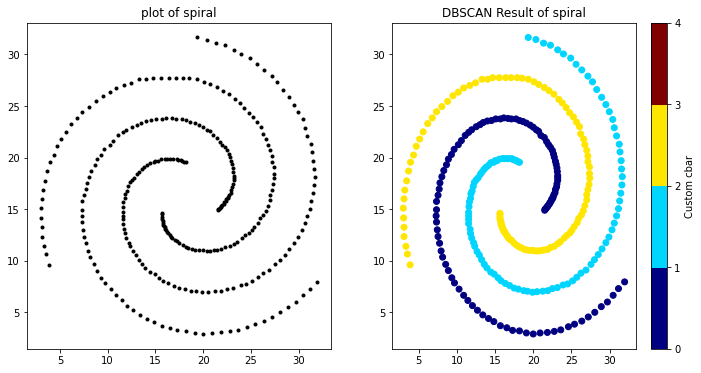

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
predict('dataset/spiral.txt', 3.6, 2, ax)

matrix_dbscan run time on flame.txt: 0.48597002029418945


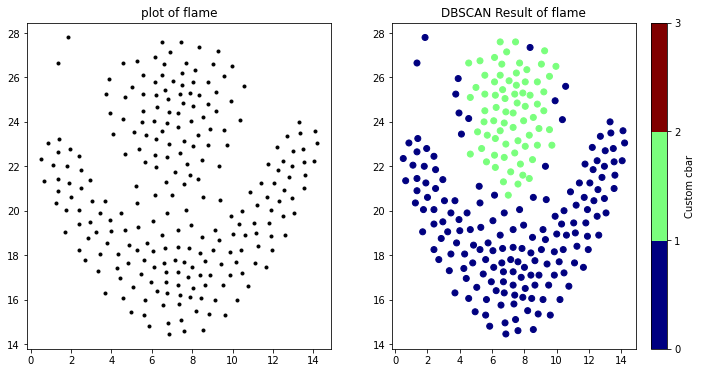

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
predict('dataset/flame.txt', 0.8, 3, ax)

matrix_dbscan run time on R15.txt: 2.9924044609069824


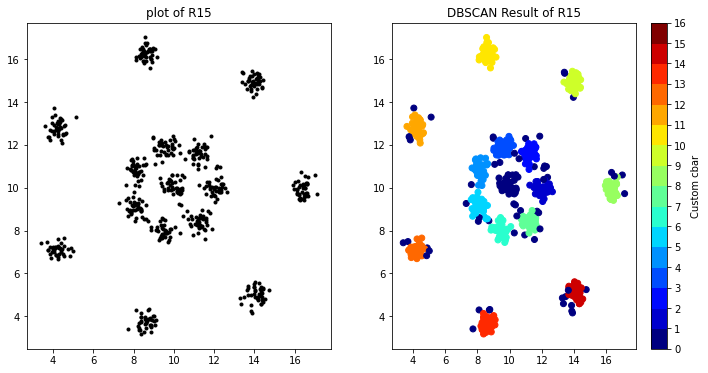

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
predict('dataset/R15.txt', 0.3, 5, ax)

matrix_dbscan run time on D31.txt: 78.08560252189636


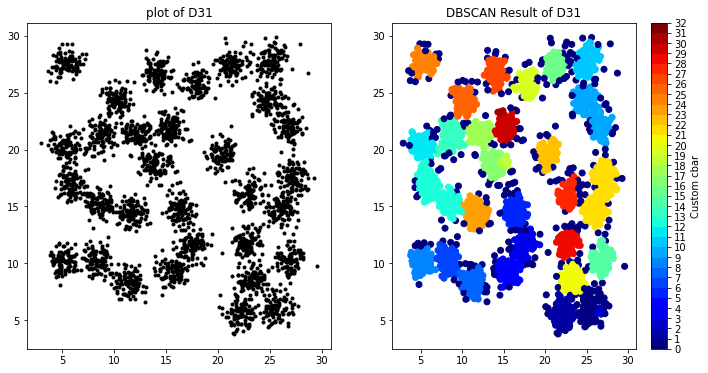

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
predict('dataset/D31.txt', 0.48, 6, ax)

KeyboardInterrupt: 

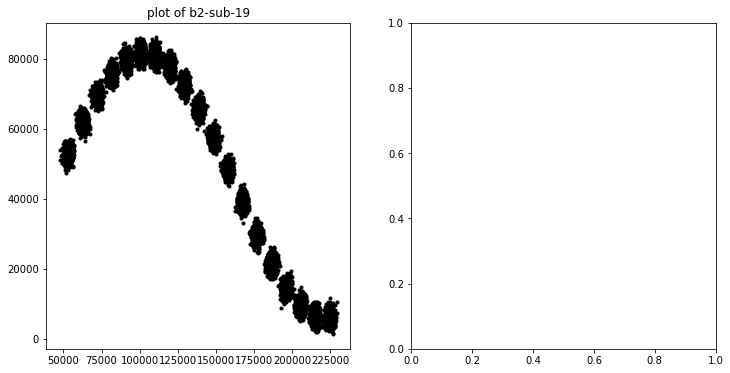

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
predict('dataset/b2-sub-19.txt', 3000, 5, ax)